# Importing  necessary liberaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyspark

In [47]:
# Additional Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Spark-specific imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, date_format, hour, to_timestamp
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time



In [48]:
# create the spark session
spark=SparkSession.builder.appName("NYC Taxi Fare Predction").getOrCreate()

# Data Loading and Inspection

In [53]:
#Load data (modify the path as necessary)
file_path = "/content/drive/MyDrive/Colab Notebooks/train.csv"
number_of_rows = 200000
min_latitude, max_latitude = -90, 90
min_longitude, max_longitude = -180, 180

In [54]:
# read csv file from google drive and show 10 rows from the dataframe
df = spark.read.csv(file_path, header=True, inferSchema=True).limit(
    number_of_rows)


In [55]:
df.show(10)

+----------+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|       key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+----------+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15|        4.5|     2009-06-15|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05|       16.9|     2010-01-05|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18|        5.7|     2011-08-18|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21|        7.7|     2012-04-21|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09|        5.3|     2010-03-09|      -73.968095|      40.768008|       -73.956655|       40.783762|              1|


In [56]:
df_new = df.withColumn("pickup_datetime", to_timestamp(col("pickup_datetime"), "yyyy-MM-dd HH:mm:ss"))

In [57]:
df_new.show(10)

+----------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|       key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+----------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15|        4.5|2009-06-15 00:00:00|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05|       16.9|2010-01-05 00:00:00|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18|        5.7|2011-08-18 00:00:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21|        7.7|2012-04-21 00:00:00|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09|        5.3|2010-03-09 00:00:00|      -73.968095|      40.768008|       -73.956655|  

In [58]:
# check for the columns, data types and if there are any null values
df_new.printSchema()

root
 |-- key: date (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [59]:
# check for the number of partitons
num_partitions = df_new.rdd.getNumPartitions()
print("Number of partitions:", num_partitions)

Number of partitions: 1


In [60]:
# count number of rows
row_count = df_new.count()
print("Number of rows:", row_count)

Number of rows: 200000


In [61]:
# checking for the statistical summary
summary_df =df_new.describe()
summary_df.show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|       fare_amount|  pickup_longitude|   pickup_latitude| dropoff_longitude| dropoff_latitude|   passenger_count|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|            200000|            200000|            200000|            199999|           199999|            200000|
|   mean|11.342876950000601|-72.50612144955218|39.922325777255104|-72.51867346221218|39.92557945791384|          1.682445|
| stddev| 9.837854787330032|11.608096802996164|10.048946659938037|10.724225862534897|6.751120031010652|1.3067296429203594|
|    min|             -44.9|           -736.55|      -3116.285383|       -1251.19589|      -1189.61544|                 0|
|    max|             500.0|        2140.60116|       1703.092772|         40.851027|       404.616667|                 6|
+-------+-------

**The minimum** fare is in negative, which is clearly erroneous (fares should not be negative).
**The maximum** fare is $93,963.36, which is extremely high and likely an outlier.

# Data Cleaning and f

In [62]:
# drop the rows with the null columns
df_new=df_new.na.drop()

In [63]:
# drop duplicates
df_new=df_new.dropDuplicates()

In [64]:
# filtering out the erroneous data
df_1 = df_new.filter(col('fare_amount') >= 0) \
               .filter((col('passenger_count') > 0) & (col('passenger_count') < 7)) \
               .filter((col('pickup_longitude') >= min_latitude) & (col('pickup_longitude') <= max_latitude)) \
               .filter((col('pickup_latitude') >= min_longitude) & (col('pickup_latitude') <= max_longitude)) \
               .filter((col('dropoff_longitude') >= min_latitude) & (col('dropoff_longitude') <= max_latitude)) \
               .filter((col('dropoff_latitude') >= min_longitude) & (col('dropoff_latitude') <= max_longitude))

# alternatively, df_new = df_new.where(col('fare_amount') >= 0)

In [65]:
# removeing outlier
q1 = df_1.approxQuantile("fare_amount", [0.25], 0.01)[0]
q3 = df_1.approxQuantile("fare_amount", [0.75], 0.01)[0]
iqr = q3 - q1

# defining upper and the lower bound
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [66]:
df_1 = df_1.filter(col('fare_amount') >= lower_bound) \
               .filter(col('fare_amount') <= upper_bound )

In [67]:
# extracting new columns from pickup_datetime
df_1 = df_1.withColumn("year", year(col("pickup_datetime"))) \
       .withColumn("month", month(col("pickup_datetime"))) \
       .withColumn("day", dayofmonth(col("pickup_datetime"))) \
       .withColumn("day_of_week", date_format(col("pickup_datetime"), 'u').cast(IntegerType())) \
       .withColumn("hour_of_day", hour(col("pickup_datetime"))) \
       .drop("key")

df_1.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)



In [21]:
df_1.show(10)

+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+----+-----+---+-----------+-----------+
|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|year|month|day|day_of_week|hour_of_day|
+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+----+-----+---+-----------+-----------+
|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|2009|    6| 15|          1|         17|
|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|2010|    1|  5|          2|         16|
|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|2011|    8| 18|          4|          0|
|        7.7|2012-04-21 04:30:42|       -73.98713|      40

# Exploratory Data Analysis (EDA)

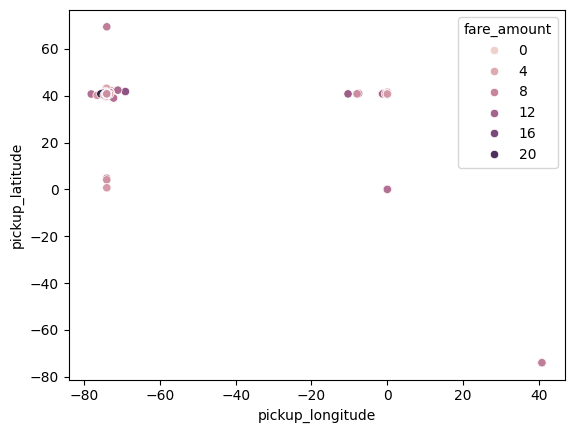

In [29]:
sns.scatterplot(x='pickup_longitude', y= 'pickup_latitude', hue='fare_amount',data=df_1.toPandas())
plt.show()

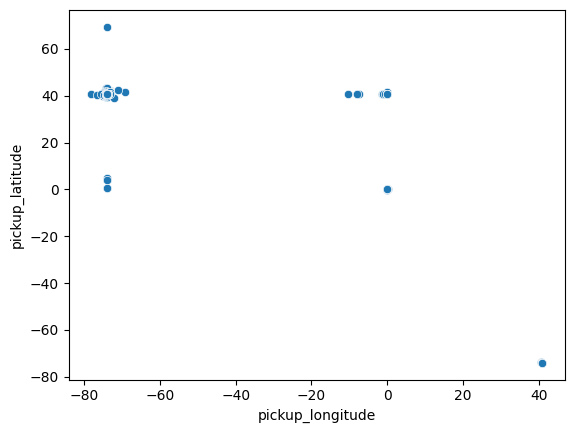

In [30]:
sns.scatterplot(x='pickup_longitude', y= 'pickup_latitude', data= df_1.toPandas())
plt.show()

In [22]:
# create tempurarty view to execute sql queries
df_1.createOrReplaceTempView("NYC_taxi_data")

In [23]:
# Mean, median, and standard deviation for numerical columns
summery_stats = """
SELECT
    AVG(fare_amount) AS avg_fare_amount,
    PERCENTILE_APPROX(fare_amount, 0.5) AS median_fare_amount,
    STDDEV(fare_amount) AS stddev_fare_amount,
    AVG(pickup_longitude) AS avg_pickup_longitude,
    AVG(pickup_latitude) AS avg_pickup_latitude,
    AVG(dropoff_longitude) AS avg_dropoff_longitude,
    AVG(dropoff_latitude) AS avg_dropoff_latitude,
    AVG(passenger_count) AS avg_passenger_count
FROM NYC_taxi_data
"""
summary_stats = spark.sql(summery_stats)
summary_stats.show()

+-----------------+------------------+------------------+--------------------+-------------------+---------------------+--------------------+-------------------+
|  avg_fare_amount|median_fare_amount|stddev_fare_amount|avg_pickup_longitude|avg_pickup_latitude|avg_dropoff_longitude|avg_dropoff_latitude|avg_passenger_count|
+-----------------+------------------+------------------+--------------------+-------------------+---------------------+--------------------+-------------------+
|9.011947439971735|               8.0| 4.265359863628189|  -72.54411620845715|  39.94258658840471|     -72.539347519805|   39.94163562162204| 1.6864320465801448|
+-----------------+------------------+------------------+--------------------+-------------------+---------------------+--------------------+-------------------+



In [24]:
# which time of the day is the busiest
busiest_hour = """
SELECT
    hour_of_day,
    COUNT(*) AS trip_count
FROM NYC_taxi_data
GROUP BY hour_of_day
ORDER BY trip_count DESC
"""
busiest_hour = spark.sql(busiest_hour)
busiest_hour.show()

+-----------+----------+
|hour_of_day|trip_count|
+-----------+----------+
|         19|     14546|
|         18|     14095|
|         20|     13723|
|         21|     13208|
|         22|     12804|
|         14|     11468|
|         23|     11281|
|         12|     11264|
|         17|     11234|
|          9|     11055|
|         13|     11026|
|         11|     10752|
|         15|     10725|
|          8|     10446|
|         10|     10324|
|         16|      9043|
|          0|      8933|
|          7|      8468|
|          1|      6611|
|          2|      5066|
+-----------+----------+
only showing top 20 rows



In [25]:
# which day of the week is the busiest day
busiest_day_of_week = """
SELECT
    day_of_week,
    COUNT(*) AS trip_count
FROM NYC_taxi_data
GROUP BY day_of_week
ORDER BY trip_count DESC
"""
busiest_day_of_week = spark.sql(busiest_day_of_week)
busiest_day_of_week.show()

+-----------+----------+
|day_of_week|trip_count|
+-----------+----------+
|          5|     35486|
|          6|     35252|
|          4|     34008|
|          3|     33408|
|          2|     31829|
|          7|     29577|
|          1|     29207|
+-----------+----------+



In [26]:
# daily trend: average fare amount and trip count per day
daily_trends = spark.sql("""
    SELECT year, month, day,
           AVG(fare_amount) AS average_fare,
           COUNT(*) AS trip_count
    FROM NYC_taxi_data
    GROUP BY year, month, day
    ORDER BY year, month, day
""")
daily_trends.show()


+----+-----+---+-----------------+----------+
|year|month|day|     average_fare|trip_count|
+----+-----+---+-----------------+----------+
|2009|    1|  1|8.127710843373498|        83|
|2009|    1|  2|8.278313253012044|        83|
|2009|    1|  3|8.487356321839078|        87|
|2009|    1|  4| 8.18024691358025|        81|
|2009|    1|  5|8.011111111111113|        72|
|2009|    1|  6|7.463440860215058|        93|
|2009|    1|  7|7.986931818181821|        88|
|2009|    1|  8|7.753846153846154|        91|
|2009|    1|  9|8.008661417322836|       127|
|2009|    1| 10|7.709677419354839|        93|
|2009|    1| 11|8.302808988764044|        89|
|2009|    1| 12| 8.18314606741573|        89|
|2009|    1| 13|8.292574257425743|       101|
|2009|    1| 14| 8.08849557522124|       113|
|2009|    1| 15|8.496634615384615|       104|
|2009|    1| 16|8.207692307692307|       117|
|2009|    1| 17| 7.88148148148148|       108|
|2009|    1| 18|7.957692307692304|        78|
|2009|    1| 19|7.239583333333336|

In [34]:
# weekly average fare and trip count by day of the week
weekly_trends = spark.sql("""
    SELECT day_of_week,
           AVG(fare_amount) AS average_fare,
           COUNT(*) AS trip_count
    FROM NYC_taxi_data
    GROUP BY day_of_week
    ORDER BY day_of_week
""")
weekly_trends.show()


+-----------+-----------------+----------+
|day_of_week|     average_fare|trip_count|
+-----------+-----------------+----------+
|          1|8.768834868353439|     29207|
|          2|8.903469477520572|     31829|
|          3| 9.01730693247123|     33408|
|          4|9.089918548576803|     34008|
|          5|9.128559150087417|     35486|
|          6|9.080634857596662|     35252|
|          7|9.051274977178233|     29577|
+-----------+-----------------+----------+



#Feature Engineering and Feature Selection

In [37]:
df_1=df_1.drop("pickup_datetime")

In [68]:
from pyspark.sql.functions import radians, cos, sin, asin, sqrt

# Define function to calculate Haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    return (
        R
        * 2
        * asin(
            sqrt(
                sin((radians(lat2) - radians(lat1)) / 2) ** 2
                + cos(radians(lat1)) * cos(radians(lat2)) * sin((radians(lon2) - radians(lon1)) / 2) ** 2
            )
        )
    )

# Apply the distance calculation
df_1 = df_1.withColumn(
    'distance_km',
    haversine_distance(
        col("pickup_latitude"), col("pickup_longitude"),
        col("dropoff_latitude"), col("dropoff_longitude")
    )
)



In [71]:
from pyspark.sql.functions import hour, dayofweek, col

# Extract temporal features and define rush hour
df_1 = df_1.withColumn("hour_of_day", hour("pickup_datetime")) \
           .withColumn("day_of_week", dayofweek("pickup_datetime")) \
           .withColumn("rush_hour", ((col("hour_of_day").between(7, 9)) | (col("hour_of_day").between(16, 18))).cast("integer"))

In [70]:
from pyspark.sql.functions import hour, dayofweek, col

# Extract temporal features and define rush hour
df_1 = df_1.withColumn("hour_of_day", hour("pickup_datetime")) \
           .withColumn("day_of_week", dayofweek("pickup_datetime")) \
           .withColumn("rush_hour", ((col("hour_of_day").between(7, 9)) | (col("hour_of_day").between(16, 18))).cast("integer"))

In [72]:
# select features and target variable
feature_columns = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude",
                   "passenger_count", "month", "day", "day_of_week", "hour_of_day"]
target_column = "fare_amount"

In [39]:
# create feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df_1)

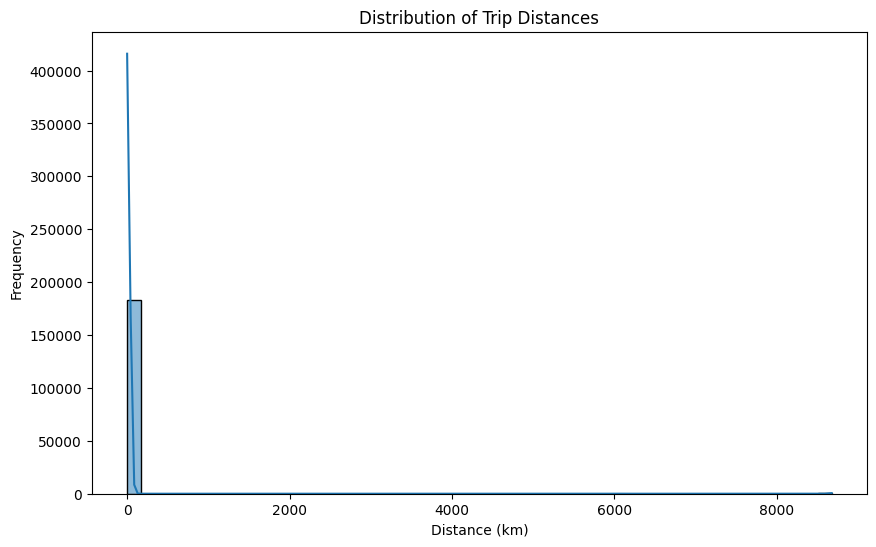

In [73]:
# Convert to Pandas for quick visualization
df_1 = df_1.select("distance_km").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_1["distance_km"], bins=50, kde=True)
plt.title("Distribution of Trip Distances")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()


# Split Data

In [40]:
final_data = data.select("features", "fare_amount")
final_data.show(10)

+--------------------+-----------+
|            features|fare_amount|
+--------------------+-----------+
|[-73.844311,40.72...|        4.5|
|[-74.016048,40.71...|       16.9|
|[-73.982738,40.76...|        5.7|
|[-73.98713,40.733...|        7.7|
|[-73.968095,40.76...|        5.3|
|[-74.000964,40.73...|       12.1|
|[-73.980002,40.75...|        7.5|
|[-73.9513,40.7741...|       16.5|
|[-74.006462,40.72...|        9.0|
|[-73.980658,40.73...|        8.9|
+--------------------+-----------+
only showing top 10 rows



In [41]:
# split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [42]:
train_data.show(10)

+--------------------+-----------+
|            features|fare_amount|
+--------------------+-----------+
|(9,[4,5,6,7],[1.0...|        6.6|
|(9,[4,5,6,7],[1.0...|        6.5|
|(9,[4,5,6,7],[1.0...|       15.0|
|(9,[4,5,6,7],[1.0...|        8.6|
|(9,[4,5,6,7],[1.0...|        7.3|
|(9,[4,5,6,7],[1.0...|        4.1|
|(9,[4,5,6,7],[1.0...|        7.3|
|(9,[4,5,6,7],[1.0...|       14.1|
|(9,[4,5,6,7],[1.0...|       16.1|
|(9,[4,5,6,7],[1.0...|        7.3|
+--------------------+-----------+
only showing top 10 rows



# Model Selection and Training

In [43]:
# initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="fare_amount")

In [44]:
# define the parameter grid for Linear Regression
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [45]:
# Evaluate model
lrevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="fare_amount", metricName="rmse")

# Create 3-fold CrossValidator
lrcv = CrossValidator(estimator = lr,
                    estimatorParamMaps = paramGrid,
                    evaluator = lrevaluator,
                    numFolds = 3)

In [46]:
# fit the model
cv_model = lrcv.fit(train_data)

# Model Evaluation

In [ ]:
# get predictions from the best model
predictions = cv_model.transform(test_data)

# evaluate the best model using RMSE
rmse = lrevaluator.evaluate(predictions)
print(f"Best Model's RMSE on test data: {rmse}")



Best Model's RMSE on test data: 4.138002179017846


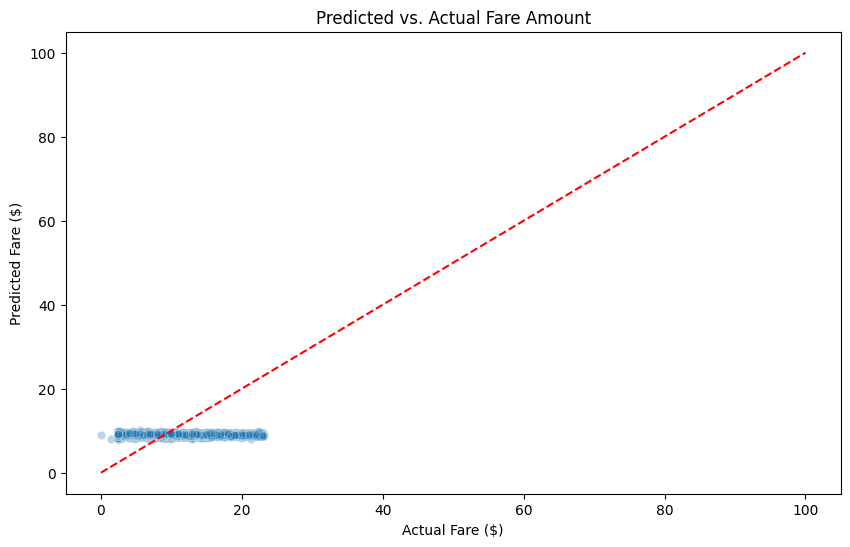

In [77]:
# Generate predictions
predictions = cv_model.transform(test_data).select("prediction", "fare_amount").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="fare_amount", y="prediction", data=predictions, alpha=0.3)
plt.plot([0, 100], [0, 100], color="red", linestyle="--")  # Line for reference
plt.title("Predicted vs. Actual Fare Amount")
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.show()
